In [1]:
import os
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

base_path = './'
train_filepath = base_path + 'train.csv'
test_filepath = base_path + 'test.csv'

if os.path.exists(train_filepath):
    print('Loading data....')
    train_data = pd.read_csv(train_filepath)
    test_data = pd.read_csv(test_filepath)
    print("\n\nShow head data")
    print(train_data.head())
    print("\n\nDescribe data")
    print(train_data.describe())
    
    print("\n\nNulls in training set")
    cols_with_missing = ['{} {} nullos de {}'.format(col,train_data[col].isnull().sum(),train_data[col].isnull().count())
                         for col in train_data.columns
                         if train_data[col].isnull().any()]
    print(cols_with_missing)
    
    print("\n\nNulls in submission set")
    cols_with_missing = ['{} {} nullos de {}'.format(col,test_data[col].isnull().sum(),test_data[col].isnull().count())
                         for col in test_data.columns
                         if test_data[col].isnull().any()]
    print(cols_with_missing)
    
    print('\n\nValues of Survived in train data')
    print(train_data['Survived'].value_counts())
    
    print('\n\nSetup and Data Loaded Complete')
else:
    print('Files not exists')

Loading data....


Show head data
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            3

## Column Selection
I delete cabin column because has many null values

In [2]:
columns_to_predict =['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'] 
X_data = train_data[columns_to_predict]
y_data = train_data['Survived']
X_send_data = test_data[columns_to_predict]
X_passenger_id = test_data['PassengerId'].copy()

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=1/5,random_state=0)

print('\nX data')
print(X_data[:10])


print('\n\nY data')
print(y_data[:10])

print('\nFinished loaded...')


X data
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  22.0      1      0   7.2500        S
1       1  female  38.0      1      0  71.2833        C
2       3  female  26.0      0      0   7.9250        S
3       1  female  35.0      1      0  53.1000        S
4       3    male  35.0      0      0   8.0500        S
5       3    male   NaN      0      0   8.4583        Q
6       1    male  54.0      0      0  51.8625        S
7       3    male   2.0      3      1  21.0750        S
8       3  female  27.0      0      2  11.1333        S
9       2  female  14.0      1      0  30.0708        C


Y data
0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

Finished loaded...


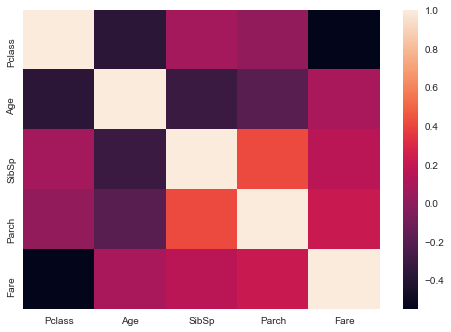

In [16]:
#Calcula la correlación entre las features, mientras más correlación, más cerca de uno está.
#Mapa de calor entre la correlación
sns.heatmap(X_data.corr())


## Column Nomalization
 I fill age with average

In [3]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(X_train['Age'].values.reshape(-1, 1))

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
X_send = X_send_data.copy()

X_train_norm.loc[:,'Age'] = imputer.transform(X_train['Age'].values.reshape(-1, 1))
X_test_norm.loc[:,'Age'] = imputer.transform(X_test['Age'].values.reshape(-1, 1))
X_send.loc[:,'Age'] = imputer.transform(X_send['Age'].values.reshape(-1, 1))

I delete 2 rows of embarked with null values


In [4]:
mask = ~pd.isnull(X_train).any(axis=1)
X_train_norm = X_train[mask]
y_train = y_train[mask]

mask = ~pd.isnull(X_test).any(axis=1)
X_test_norm = X_test[mask]
y_test = y_test[mask] 

I fill with the mean the Fare row in submission data

In [5]:
from sklearn.impute import SimpleImputer

imputerFare = SimpleImputer(missing_values=np.nan,strategy='mean')
imputerFare = imputerFare.fit(X_train['Fare'].values.reshape(-1, 1))

X_send.loc[:,'Fare'] = imputerFare.transform(X_send['Fare'].values.reshape(-1, 1))

I applied one hot encoder to sex and embarked

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
object_cols = ['Sex','Embarked']
columns = ['']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train_norm[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test_norm[object_cols]))
OH_cols_send = pd.DataFrame(OH_encoder.transform(X_send[object_cols]))


# One-hot encoding removed index; put it back
OH_cols_train.index = X_train_norm.index
OH_cols_test.index = X_test_norm.index
OH_cols_send.index = X_send.index


columns = []
column = ''
columns_to_drop = []
for encoder in OH_encoder.categories_:
    for column in encoder:
        columns.append('is_{}'.format(column))
    columns_to_drop.append('is_{}'.format(column))
    
OH_cols_train.columns = columns
OH_cols_test.columns = columns
OH_cols_send.columns = columns

OH_cols_train = OH_cols_train.drop(columns_to_drop,axis=1)
OH_cols_test =OH_cols_test.drop(columns_to_drop,axis=1)
OH_cols_send =OH_cols_send.drop(columns_to_drop,axis=1)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train_norm = X_train_norm.drop(object_cols, axis=1)
num_X_test_norm = X_test_norm.drop(object_cols, axis=1)
num_X_send = X_send.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train_norm, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test_norm, OH_cols_test], axis=1)
OH_X_send = pd.concat([num_X_send, OH_cols_send], axis=1)

print(OH_X_train)


     Pclass   Age  SibSp  Parch      Fare  is_female  is_C  is_Q
439       2  31.0      0      0   10.5000        0.0   0.0   0.0
817       2  31.0      1      1   37.0042        0.0   1.0   0.0
378       3  20.0      0      0    4.0125        0.0   1.0   0.0
491       3  21.0      0      0    7.2500        0.0   0.0   0.0
331       1  45.5      0      0   28.5000        0.0   0.0   0.0
..      ...   ...    ...    ...       ...        ...   ...   ...
763       1  36.0      1      2  120.0000        1.0   0.0   0.0
835       1  39.0      1      1   83.1583        1.0   1.0   0.0
192       3  19.0      1      0    7.8542        1.0   0.0   0.0
559       3  36.0      1      0   17.4000        1.0   0.0   0.0
684       2  60.0      1      1   39.0000        0.0   0.0   0.0

[569 rows x 8 columns]


In [10]:
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(2)
#Obtiene los datos x  y x2y2 xy
X_train_poli = transformer.fit_transform(OH_X_train)
X_test_poli = transformer.transform(OH_X_test)
X_send_poli = transformer.transform(OH_X_send)

print(X_train_poli[:10])

[[1.00000000e+00 2.00000000e+00 3.10000000e+01 0.00000000e+00
  0.00000000e+00 1.05000000e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.00000000e+00 6.20000000e+01 0.00000000e+00
  0.00000000e+00 2.10000000e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.61000000e+02 0.00000000e+00 0.00000000e+00
  3.25500000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.10250000e+02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 2.00000000e+00 3.10000000e+01 1.00000000e+00
  1.00000000e+00 3.70042000e+01 0.00000000e+00 1.00000000e+00
  0.00000000e+00 4.00000000e+00 6.20000000e+01 2.00000000e+00
  2.00000000e+00 7.40084000e+01 0.00000000e+00 2.00000000e+00
  0.00000000e+00 9.61000000e+02 3.10000000e+01 3.100

In [11]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_trainf = sc_X.fit_transform(X_train_poli)
X_testf = sc_X.transform(X_test_poli)
X_sendf = sc_X.transform(X_send_poli)


print(X_trainf[:10])

print('Finished preprocessing')

[[ 0.         -0.29244176  0.09104097 -0.54710127 -0.50182111 -0.43987676
  -0.73054276 -0.45895348 -0.20524264 -0.50449008 -0.00390245 -0.45845173
  -0.43688382 -0.59342633 -0.65312464 -0.4007232  -0.20222254 -0.13245188
  -0.57373897 -0.35187868 -0.38121236 -0.61721911 -0.40246641 -0.17532427
  -0.31990835 -0.33695023 -0.35121845 -0.35917101 -0.25516556 -0.09166082
  -0.30312542 -0.31187052 -0.35092606 -0.21477452 -0.07676426 -0.18839612
  -0.38356332 -0.24784843 -0.13675188 -0.73054276 -0.29304925 -0.12677314
  -0.45895348  0.         -0.20524264]
 [ 0.         -0.29244176  0.09104097  0.55290093  0.65419594  0.05799956
  -0.73054276  2.17887006 -0.20524264 -0.50449008 -0.00390245  0.32608672
   0.44934397  0.40795647 -0.65312464  2.20512251 -0.20222254 -0.13245188
   1.09297958  0.67424872  0.03261667 -0.61721911  1.91617653 -0.17532427
  -0.02199043  0.30426944  0.22076431 -0.35917101  3.37456459 -0.09166082
   0.02047376  0.16479653 -0.35092606  2.76587673 -0.07676426 -0.12716685

## Model

### Linear SVC
Selecting best model Linear SVC

In [ ]:
#Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [
    {'penalty':['l1'],'dual':[False],'C':np.arange(0, 20, 1).tolist(),
     'max_iter':np.arange(5000,20000, 1000).tolist(),'tol':np.arange(0.0001, 0.001, 0.0001).tolist()}
]
grid_search = GridSearchCV(estimator=LinearSVC(),
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=3,
                         n_jobs=-1)
grid_search = grid_search.fit(X_trainf,y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best accuracy {}%".format(best_accuracy*100))
print("Best pameters \n {}".format(best_parameters))

#### Best model Linear SVC

Position 9846

Score 0.77511

Precision 78.96%

Variance 15.81%

TRAIN

True positives 292 -
False positives 48 -
False negative 69 -
True negative 160 -


TEST

True positives 69 -
False positives 15 -
False negative 13 -
True negative 46 -

In [14]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

best_model = LinearSVC(max_iter=10000,dual=False, tol=0.0007, C=5.5,penalty='l1')
best_model.fit(X_trainf, y_train)

LinearSVC(C=5.5, dual=False, max_iter=10000, penalty='l1', tol=0.0007)

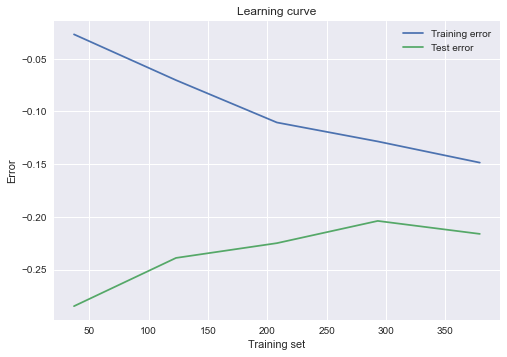

In [16]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=LinearSVC(max_iter=10000,dual=False, tol=0.0007, C=5.5,penalty='l1'),
                    X=X_trainf,
                    y=y_train,
                    scoring = 'neg_mean_squared_error',
                    cv=3,
                    n_jobs=-1)
#Gráfico la curva de aprendizaje
plt.style.use('seaborn')
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = 'Training error')
plt.plot(train_sizes,np.mean(test_scores ,axis=1), label = 'Test error')
plt.xlabel("Training set")
plt.ylabel("Error")
plt.title("Learning curve")
plt.legend()
plt.show()

### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

best_model = KNeighborsClassifier(n_neighbors=5,
                                  weights='uniform', 
                                  algorithm='auto', 
                                  leaf_size=30,
                                  p=2, metric='minkowski', 
                                  n_jobs=-1)

In [ ]:
#Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [
    {'n_neighbors':np.arange(0, 10, 1).tolist(),
     'weights':['uniform','distance'],
     'algorithm':['ball_tree','kd_tree','brute'],
     'leaf_size': np.arange(0,100, 10).tolist(),
     'p':[1,2],
     'metric':['euclidean','manhattan','chebyshev','minkowski','wminkowski','seuclidean','mahalanobis']}
]
grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=3,
                         n_jobs=-1)
grid_search = grid_search.fit(X_trainf,y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best accuracy {}%".format(best_accuracy*100))
print("Best pameters \n {}".format(best_parameters))

## Test

In [15]:
from sklearn.metrics import confusion_matrix

y_predict = best_model.predict(X_trainf)
cm = confusion_matrix(y_train,y_predict)
print("TRAIN\nTrue positives {} \nFalse positives {} \nFalse negative {} \nTrue negative {}\n\n".format(cm[0][0],cm[0][1],cm[1][0],cm[1][1]))

y_predict_test = best_model.predict(X_testf)
cm = confusion_matrix(y_test,y_predict_test)
print("TEST\nTrue positives {} \nFalse positives {} \nFalse negative {} \nTrue negative {}\n\n".format(cm[0][0],cm[0][1],cm[1][0],cm[1][1]))


#Applying k-Flod Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=best_model, X=X_trainf, y=y_train, cv=100)


print("Precision {}%".format(accuracies.mean()*100))
#Indica la varianza
print("Variance {}%".format(accuracies.std()*100))


TRAIN
True positives 310 
False positives 30 
False negative 64 
True negative 165


TEST
True positives 70 
False positives 14 
False negative 15 
True negative 44


Precision 79.16666666666666%
Variance 16.01648456365434%


## Submission

In [149]:
best_model.fit(X_testf,y_test)
y_send = best_model.predict(X_sendf)

data = {'PassengerId': X_passenger_id,
        'Survived': y_send}

df = pd.DataFrame (data)
df.to_csv('submission.csv',index=False)
